# aws wrangler - PostgreSQL serverless

[Wrangler](https://github.com/awslabs/aws-data-wrangler)'s Database module (`wr.db.*`) has two mainly functions that tries to follow the Pandas conventions, but add more data type consistency.

- [wr.db.to_sql()](https://aws-data-wrangler.readthedocs.io/en/latest/stubs/awswrangler.db.to_sql.html#awswrangler.db.to_sql)

- [wr.db.read_sql_query()](https://aws-data-wrangler.readthedocs.io/en/latest/stubs/awswrangler.db.read_sql_query.html#awswrangler.db.read_sql_query)

In [ ]:
!pip install awswrangler
# geopandas
!pip install geopandas
!pip install descartes
# geoalchemy
!pip install geoalchemy2

In [1]:
import awswrangler as wr
import pandas as pd

df = pd.DataFrame({
    "id": [1, 2],
    "name": ["foo", "boo"]
})

### Creating an engine (SQLAlchemy Engine)

The Wrangler offers basically three diffent ways to create a SQLAlchemy engine.

1 - [wr.catalog.get_engine()](https://aws-data-wrangler.readthedocs.io/en/latest/stubs/awswrangler.catalog.get_engine.html#awswrangler.catalog.get_engine): Get the engine from a Glue Catalog Connection.

2 - [wr.db.get_engine()](https://aws-data-wrangler.readthedocs.io/en/latest/stubs/awswrangler.db.get_engine.html#awswrangler.db.get_engine): Get the engine from primitives values (host, user, password, etc).

3 - [wr.db.get_redshift_temp_engine()](https://aws-data-wrangler.readthedocs.io/en/latest/stubs/awswrangler.db.get_redshift_temp_engine.html#awswrangler.db.get_redshift_temp_engine): Get redshift engine with temporary credentials. 

In [2]:
eng_postgresql = wr.catalog.get_engine("aws-data-wrangler-postgresql")

## Raw SQL queries (No Pandas)

In [3]:
with eng_postgresql.connect() as con:
    for row in con.execute("SELECT 1"):
        print(row)

(1,)


## Loading data to Database

In [4]:
wr.db.to_sql(df, eng_postgresql, schema="public", name="tutorial", if_exists="replace", index=False)  # PostgreSQL

## Unloading data from Database

In [5]:
wr.db.read_sql_query("SELECT * FROM public.tutorial", con=eng_postgresql)  # PostgreSQL

,id,name
0,1,foo
1,2,boo


# GeoSpatial

In [6]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

In [7]:
df = pd.DataFrame(
    {'City': ['Buenos Aires', 'Brasilia', 'Santiago', 'Bogota', 'Caracas'],
     'Country': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela'],
     'Latitude': [-34.58, -15.78, -33.45, 4.60, 10.48],
     'Longitude': [-58.66, -47.91, -70.66, -74.08, -66.86]})

In [8]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))

In [9]:
gdf.head()

,City,Country,Latitude,Longitude,geometry
0,Buenos Aires,Argentina,-34.58,-58.66,POINT (-58.66000 -34.58000)
1,Brasilia,Brazil,-15.78,-47.91,POINT (-47.91000 -15.78000)
2,Santiago,Chile,-33.45,-70.66,POINT (-70.66000 -33.45000)
3,Bogota,Colombia,4.60,-74.08,POINT (-74.08000 4.60000)
4,Caracas,Venezuela,10.48,-66.86,POINT (-66.86000 10.48000)


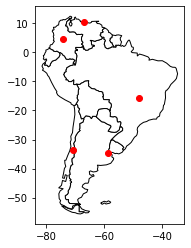

In [10]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()

# Enable the postgis in serverless postgres
```
CREATE EXTENSION postgis;
CREATE EXTENSION postgis_topology;
CREATE EXTENSION address_standardizer;
CREATE EXTENSION address_standardizer_data_us;
CREATE EXTENSION fuzzystrmatch;
CREATE EXTENSION postgis_tiger_geocoder;
select postgis_full_version();
```

In [12]:
resultproxy=eng_postgresql.execute('select postgis_full_version()')
[{column: value for column, value in rowproxy.items()} for rowproxy in resultproxy]

[{'postgis_full_version': 'POSTGIS="2.4.4" PGSQL="100" GEOS="3.6.2-CAPI-1.10.2 4d2925d6" PROJ="Rel. 4.9.3, 15 August 2016" GDAL="GDAL 2.1.4, released 2017/06/23" LIBXML="2.9.3" LIBJSON="0.12.99" LIBPROTOBUF="1.3.0" (core procs from "2.4.4" need upgrade) RASTER (raster procs from "2.4.4" need upgrade)'}]

In [ ]:
sql_postgis='''
CREATE EXTENSION postgis;
CREATE EXTENSION postgis_topology;
CREATE EXTENSION address_standardizer;
CREATE EXTENSION address_standardizer_data_us;
CREATE EXTENSION fuzzystrmatch;
CREATE EXTENSION postgis_tiger_geocoder;
'''

In [ ]:
eng_postgresql.execute(sql_postgis, multi=True)

In [13]:
# This method requires SQLAlchemy and GeoAlchemy2, and a PostgreSQL Python driver (e.g. psycopg2) to be installed.
gdf.to_postgis("geospatial", eng_postgresql, schema='public', if_exists='replace',index=False)

In [14]:
wr.db.read_sql_query("SELECT * FROM public.geospatial", con=eng_postgresql)

,City,Country,Latitude,Longitude,geometry
0,Buenos Aires,Argentina,-34.58,-58.66,010100000014AE47E17A544DC00AD7A3703D4A41C0
1,Brasilia,Brazil,-15.78,-47.91,010100000014AE47E17AF447C08FC2F5285C8F2FC0
2,Santiago,Chile,-33.45,-70.66,01010000000AD7A3703DAA51C09A99999999B940C0
3,Bogota,Colombia,4.60,-74.08,010100000085EB51B81E8552C06666666666661240
4,Caracas,Venezuela,10.48,-66.86,0101000000D7A3703D0AB750C0F6285C8FC2F52440


In [15]:
sql = "SELECT * FROM geospatial"
geopandas.GeoDataFrame.from_postgis(sql, eng_postgresql,geom_col='geometry')

,City,Country,Latitude,Longitude,geometry
0,Buenos Aires,Argentina,-34.58,-58.66,POINT (-58.66000 -34.58000)
1,Brasilia,Brazil,-15.78,-47.91,POINT (-47.91000 -15.78000)
2,Santiago,Chile,-33.45,-70.66,POINT (-70.66000 -33.45000)
3,Bogota,Colombia,4.60,-74.08,POINT (-74.08000 4.60000)
4,Caracas,Venezuela,10.48,-66.86,POINT (-66.86000 10.48000)


In [16]:
sql='''
SELECT table_name, column_name, data_type 
FROM
   information_schema.columns
WHERE 
   table_name = 'geospatial';
'''

In [17]:
wr.db.read_sql_query(sql, con=eng_postgresql)

,table_name,column_name,data_type
0,geospatial,City,text
1,geospatial,Country,text
2,geospatial,Latitude,double precision
3,geospatial,Longitude,double precision
4,geospatial,geometry,USER-DEFINED


## Use sql statement to create geospatial table

In [ ]:
sqlCreateTable='''
CREATE TABLE public.geotutorial (
    "City" TEXT, 
    "Country" TEXT, 
    "Latitude" DOUBLE PRECISION, 
    "Longitude" DOUBLE PRECISION, 
    geometry geometry(POINT,4326)
)
'''
eng_postgresql.execute(sqlCreateTable)

In [ ]:
sql='''
SELECT table_name, column_name, data_type 
FROM
   information_schema.columns
WHERE 
   table_name = 'geotutorial';
'''
wr.db.read_sql_query(sql, con=eng_postgresql)

In [ ]:
# from geoalchemy2 import Geometry, WKTElemen
# wr.db.to_sql(gdf, eng_postgresql, schema="public", name="geospatial", if_exists="replace", index=False, 
#             dtype={'geometry': Geometry('POINT', srid=4326)})  # PostgreSQL